[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Training with Spiking Speech Commands snnTorch Tutorial

##### By: Richard Dao (rqdao@ucsc.edu), Annabel Truong (anptruon@ucsc.edu), Mira Prabhakar (miprabha@ucsc.edu)

<a href="https://colab.research.google.com/drive/17W8Q_jhssnjWuPnGqK6RkWtVqHeS57gq#scrollTo=69E4SzHiFC28">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:


> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

This example tutorial will cover training spiking neural networks for an audio-based classication dataset.

**In this tutorial. you will:**

*   Learn how to load SCC, an audio-based classification dataset, using tonic
*   Understand Visualization, transformations and batching
*   Train the SNN

**If running in Google Colab:**


*   You may connect to GPU by checking Runtime > Change runtime type > Hardware accelerator: GPU
*   Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing Shift+Enter.




First, install the snntorch library if it is not already installed on your machine.

In [ ]:
!pip install snntorch --quiet
!pip install tonic --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.0 MB/s eta 0:00:00


And then we need to import some libraries to use for this project.

In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tonic import collation, datasets, DiskCachedDataset, transforms
import torchaudio

# snnTorch
import snntorch as snn
from snntorch import functional, utils

# Tonic
import tonic

# Other
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn
import os

from sklearn.model_selection import train_test_split
from IPython.display import HTML, display


# 1. The Spiking Speech Commands (SSC) Dataset

**An explanation on the data:**


*   The Spiking Speech Commands (SSC) Dataset was generated using Lauscher, an artificial cochlea model. SSC is a spiking version of Google’s Speech Commands dataset and contains over 100,00 samples of waveform audio data.
*   The dataset contains 35 classes: Yes, No, Up, Down, Left, Right, On, Off, Stop, Go, Backward, Forward, Follow, Learn, Bed, Bird, Cat, Dog, Happy, House, Marvin, Sheila, Tree, Wow, Zero, One, Two, Three, Four, Five, Six, Seven, Eight, Nine


Tonic will be used to convert the dataset into a format compatible with PyTorch/snnTorch. The documentation for Tonic can be found [here](https://tonic.readthedocs.io/en/latest/generated/tonic.datasets.SSC.html).

For the purposes of this tutorial, we use Google Colab. If you use your local notebook, you should edit the following cell to save the dataset locally.

To access the data you may need to authorize the following in your Google Drive. After the following, change the root file to your own path.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/'
ext = 'snnTorch Research Project' # Use for developing

path = os.path.join(root, ext)

Mounted at /content/drive


# 2. Data Preprocessing using Tonic

After the data is successfully mounted to your drive, we will begin the data visualization using tonic.

The event tuples are formatted of type `(t, x, p)`:

*   `t` is time stamp
*   `x` is the audio channel
*   `p` is a boolean value that is always 0


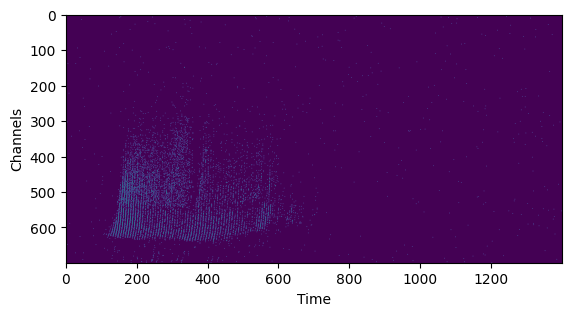

In [ ]:
dataset = tonic.datasets.SSC(save_to=path, split='train')

events, target = dataset[2]
tonic.utils.plot_event_grid(events)

In [ ]:
print(events.dtype)

[('t', '<i8'), ('x', '<i8'), ('p', '<i8')]


## 2.1 Downsampling

We decided to downsample our data for efficiency purposes for this tutorial. While this means we could potentially lose important datapoints, it allows us to save significant computation time.

For the purposes of this tutorial, we downsampled to 375 channels, a downsampling factor of 1/2.

In [ ]:
# Courtesy of Rockpool.AI for their images on the SHD dataset (sister dataset of SSC)
%%html
<p style="font-size: 115%;">Downsampling allows us to turn data like this:</p>
<br>
<img src=https://rockpool.ai/_images/tutorials_rockpool-shd_4_0.png style="width:30%">
<br>
<p style="font-size: 115%;">Into this:</p>
<br>
<img src=https://rockpool.ai/_images/tutorials_rockpool-shd_14_0.png style="width: 30%;">

In [ ]:
sensor_size = datasets.SSC.sensor_size # By default is (700, 1, 1)
time_step = 12000 # The max time steps
downsample_factor = 1/2 # Change as needed

toTensorTransform = transforms.Compose([
    transforms.Downsample(spatial_factor=downsample_factor),
    transforms.ToFrame(sensor_size=(700 // int(1 / downsample_factor), 1, 1), time_window=time_step)
])


train_dataset = tonic.datasets.SSC(save_to=path, split='train', transform=toTensorTransform)
validation_dataset = tonic.datasets.SSC(save_to=path, split='valid', transform=toTensorTransform)
test_dataset = tonic.datasets.SSC(save_to=path, split='test', transform=toTensorTransform)

# 3. DataLoading and Batching


Since the original data is stored in a format that is slow to read, we utilize disk caching and batching. This allows us to wrute files that are loaded from the original dataset to the disk for quick re-use.

Because event recordings will have different lengths, we are going to provide a collation function `tonic.collation.PadTensors()` that will pad out shorter recordings to ensure all samples in a batch have the same dimensions for our DataLoaders.

In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False))
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False))

cached_train_dataloader = DiskCachedDataset(train_dataset, cache_path="./cache/dataloader_train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False), num_workers=2)

cached_validation_dataloader = DiskCachedDataset(validation_dataset, cache_path="./cache/dataloader_validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False), num_workers=2)

cached_test_dataloader = DiskCachedDataset(test_dataset, cache_path="./cache/dataloader_test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collation.PadTensors(batch_first=False), num_workers=2)

# Storing all the dataloaders in a dictionary
dataloaders = {
    'train':train_dataloader,
    'validation':validation_dataloader,
    'test':test_dataloader
}


Note the shape of our event tensors are: time x batch x dimensions

In [ ]:
data_tensor, targets = next(iter(train_dataloader))
print(data_tensor.shape)

torch.Size([83, 128, 1, 350])


# 4. Network Architecture
We will use snnTorch and PyTroch to construct a Spiking Multi-Layered Perceptron (SMLP).

We use 3 hidden layers separated by leaky neurons and a final dropout layer before our output layer. Note that we also specify a surrogate gradient *atan* with an alpha=2.

In [ ]:
# Defining the Network Architecture
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

inputs = int(700 * downsample_factor)
hidden = 512
outputs = 35

beta = 0.95
lr = 0.0001

surrogate = snn.surrogate.atan(alpha=2)

model = nn.Sequential(
    # Define network architecture here
    nn.Linear(inputs, hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate, init_hidden=True),

    nn.Linear(hidden, hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate, init_hidden=True),

    nn.Linear(hidden, hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate, init_hidden=True),

    nn.Linear(hidden, hidden),
    snn.Leaky(beta=beta, spike_grad=surrogate, init_hidden=True),

    nn.Dropout(0.4),

    nn.Linear(hidden, outputs),
    snn.Leaky(beta=beta, spike_grad=surrogate, init_hidden=True, output=True),

).to(device)


## 4.1 Loss Function and Optimizer

For this tutorial, we found that Adam and Mean Squared Error Spike Count Loss performed best.

*Mean Squared Error Spike Count Loss* obtains spikes from the correct class a % of the time and spikes from the incorrect classes a % of the time to encourage incorrect neurons to fire and avoid them from dying.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = lr, betas=(0.9, 0.999))
criterion = functional.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# 5. Define the Forward Pass

The standard forward pass we use for spiking neural networks, we keep track of the total number of spikes and reset the hidden states for all Leaky neurons in our network.

Note that data.size(0) is the number of time steps at each iteration.

In [ ]:
def forward(net, data):
    total_spikes = [] # collect total number of spikes
    utils.reset(net) # reset hidden states of all Leaky neurons

    for i in range(data.size(0)): # loop over number of timesteps
        output_spikes, mem_out = net(data[i])
        total_spikes.append(output_spikes)

    return torch.stack(total_spikes)

For organization, we will store the loss and accuracy histories in dictionaries.

In [ ]:
loss_history = {
    'train':[],
    'validation':[],
    'test':[]
}
accuracy_history = {
    'train':[],
    'validation':[],
    'test':[]
}

# 6. Training
Training neuromorphic data takes a large amount of computation time as it requires seqeuentially iterating through time steps. In the case of the SSC dataset, there are roughly 600 timesteps that will be run per epoch.

In our own experiments, it took about 10 epochs with 600 iterations each to crack ~55% validation accuracy.

> Warning: the following simulation will take a while. In our own experiments, it took about 2 hours to train 10 epochs of 600 iterations.

In [ ]:
# Training Loop
num_epochs = 10

from tqdm.autonotebook import tqdm

with tqdm(range(num_epochs), unit='Epoch', desc='Training') as pbar:
    epoch = 0
    for _ in pbar:
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for i, (events, labels) in enumerate(dataloaders[phase]):
                events = events.squeeze()
                events, labels = events.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    spk_rec = forward(model, events)
                    loss = criterion(spk_rec, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    if i % 25 == 0:
                        loss_history[phase].append(loss.item())
                        accuracy = functional.accuracy_rate(spk_rec, labels)
                        accuracy_history[phase].append(accuracy)
                        print(f"Epoch {epoch+1}, Iteration {i} \n{phase} loss: {loss.item():.2f}")
                        print(f"Accuracy: {accuracy * 100:.2f}%\n")

        epoch += 1


Training:   0%|          | 0/10 [00:00<?, ?Epoch/s]

Epoch 0, Iteration 0 
train loss: 4.48
Accuracy: 3.91%

Epoch 0, Iteration 25 
train loss: 1.87
Accuracy: 3.91%

Epoch 0, Iteration 50 
train loss: 1.08
Accuracy: 4.69%

Epoch 0, Iteration 75 
train loss: 0.99
Accuracy: 3.91%

Epoch 0, Iteration 100 
train loss: 0.99
Accuracy: 3.12%

Epoch 0, Iteration 125 
train loss: 0.94
Accuracy: 3.91%

Epoch 0, Iteration 150 
train loss: 0.95
Accuracy: 3.12%

Epoch 0, Iteration 175 
train loss: 0.96
Accuracy: 7.81%

Epoch 0, Iteration 200 
train loss: 0.90
Accuracy: 5.47%

Epoch 0, Iteration 225 
train loss: 0.89
Accuracy: 7.03%

Epoch 0, Iteration 250 
train loss: 0.87
Accuracy: 3.91%

Epoch 0, Iteration 275 
train loss: 0.85
Accuracy: 8.59%

Epoch 0, Iteration 300 
train loss: 0.84
Accuracy: 7.81%

Epoch 0, Iteration 325 
train loss: 0.83
Accuracy: 10.16%

Epoch 0, Iteration 350 
train loss: 0.83
Accuracy: 10.16%

Epoch 0, Iteration 375 
train loss: 0.82
Accuracy: 21.09%

Epoch 0, Iteration 400 
train loss: 0.83
Accuracy: 10.16%

Epoch 0, Iterat

# 7. Results

We plot and compare the accuracy and loss of the different splits of the dataset.

## 7.1 Plot Train and Validation Set Accuracy

Note that we recorded accuracies and losses every **25** iterations. You can see that our graphs, while jumpy, show an upward trend in accuracy with little overfitting.

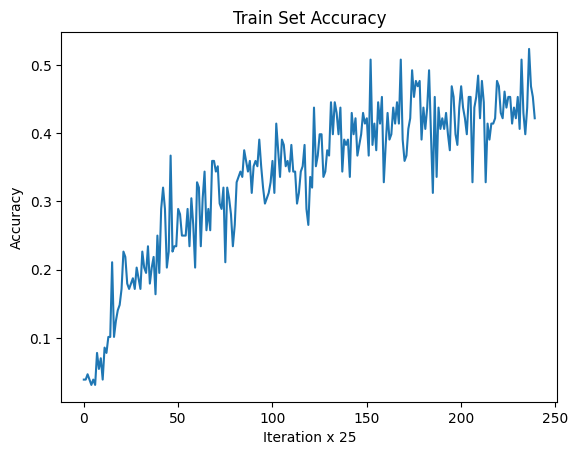

In [ ]:
train_fig = plt.figure(facecolor="w")
plt.plot(accuracy_history['train'])
plt.title("Train Set Accuracy")
plt.xlabel("Iteration x 25")
plt.ylabel("Accuracy")
plt.show()

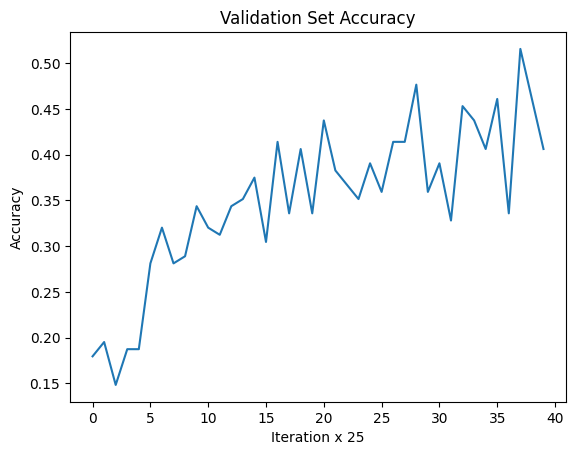

In [ ]:
val_fig = plt.figure(facecolor="w")
plt.plot(accuracy_history['validation'])
plt.title("Validation Set Accuracy")
plt.xlabel("Iteration x 25")
plt.ylabel("Accuracy")
plt.show()

## 7.2 Testing Our Dataset

Tonic provides us a test dataset for SSC from which we can use to test the average accuracy of our model.

In [ ]:
model.eval()

with torch.no_grad():
    for i, (events, labels) in enumerate(dataloaders['test']):
        events = events.squeeze()
        events, labels = events.to(device), labels.to(device)

        spk_rec = forward(model, events)
        loss = criterion(spk_rec, labels)
        if i % 50 == 0:
            loss_history['test'].append(loss.item())
            accuracy = functional.accuracy_rate(spk_rec, labels)
            accuracy_history['test'].append(accuracy)

On average, we get around the 40% accuracy range for our test set.

In [ ]:
print("Average Accuracy of Test Dataset: ", str(np.mean(accuracy_history['test']) * 100) + "%")

Average Accuracy of Test Dataset:  43.8380238791423%


Finally, some comparison graphs over the entire training time.

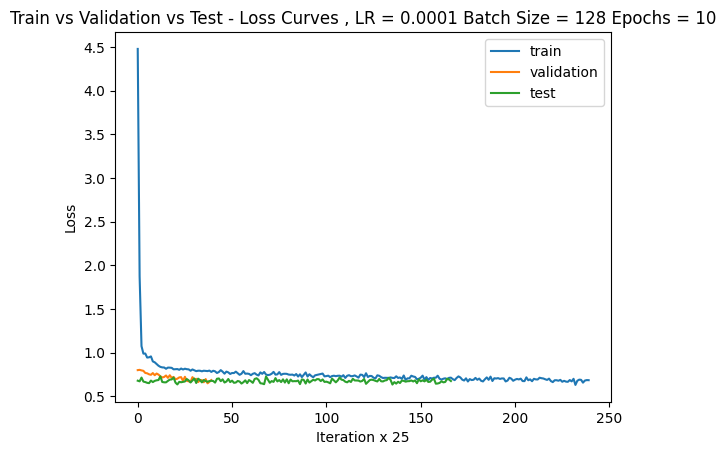

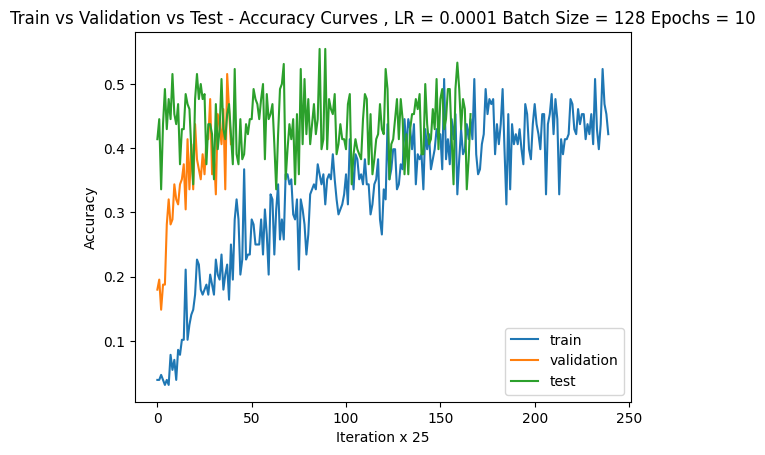

In [ ]:
loss_comparison_fig = plt.figure(facecolor="w")
plt.plot(loss_history['train'], label='train')
plt.plot(loss_history['validation'], label='validation')
plt.plot(loss_history['test'], label='test')
plt.legend(loc='best')
plt.title(f"Train vs Validation vs Test - Loss Curves , LR = {lr} Batch Size = {batch_size} Epochs = {num_epochs}")
plt.xlabel("Iteration x 25")
plt.ylabel("Loss")
plt.show()

accuracy_comparison_fig = plt.figure(facecolor="w")
plt.plot(accuracy_history['train'], label='train')
plt.plot(accuracy_history['validation'], label='validation')
plt.plot(accuracy_history['test'], label='test')
plt.legend(loc='best')
plt.title(f"Train vs Validation vs Test - Accuracy Curves , LR = {lr} Batch Size = {batch_size} Epochs = {num_epochs}")
plt.xlabel("Iteration x 25")
plt.ylabel("Accuracy")
plt.show()

# Congrats! We're all done!
You trained a Spiking Neural Network using ``snnTorch`` and ``Tonic`` on SSC!